# Installation et imports 

In [101]:
!pip install pandas numpy matplotlib seaborn plotly nbformat==5.8.0 scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat
import sklearn
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder


# Infos basique du dataset 

In [103]:
# Load the data
df = pd.read_csv('Food_Delivery_Times.csv')
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [104]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [105]:
df.shape

(1000, 9)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


# EDA 

<Axes: >

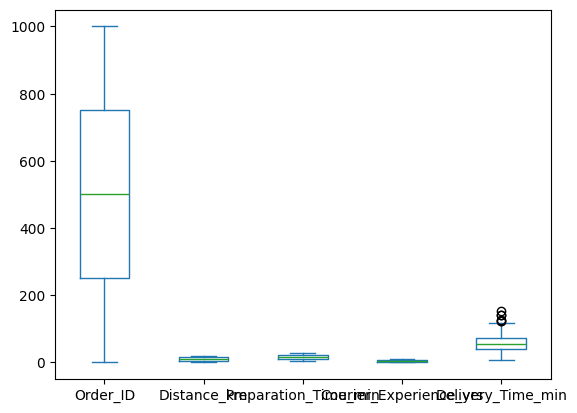

In [107]:
df.plot.box()

On constate que Order_ID n'est pas utile et que Delivery_Time_min affiche des valeurs bizarre. On va commencer par drop Order_ID car on ne va pas s'en servir. Il peut amner a confusion et faire bugger le modele comme c'est une valeur unique. Le modele va faire du par coeur ce qui n'est pas interessant pour nous. On va aussi drop les lignes avec des valeurs manquantes. On a 1000 ligne en tout donc l'impact n'est pas grand. 

In [108]:
#Drop the Order_ID column
df1 = df.drop(['Order_ID'], axis=1)

#Drop the rows with missing values
df1.dropna(subset=['Weather','Traffic_Level','Time_of_Day','Courier_Experience_yrs'],inplace=True)

#Check for missing values
df1.isnull().sum()

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

In [109]:
df1.shape

(883, 8)

C:\Users\hayek\AppData\Local\Temp\ipykernel_4064\1668234538.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




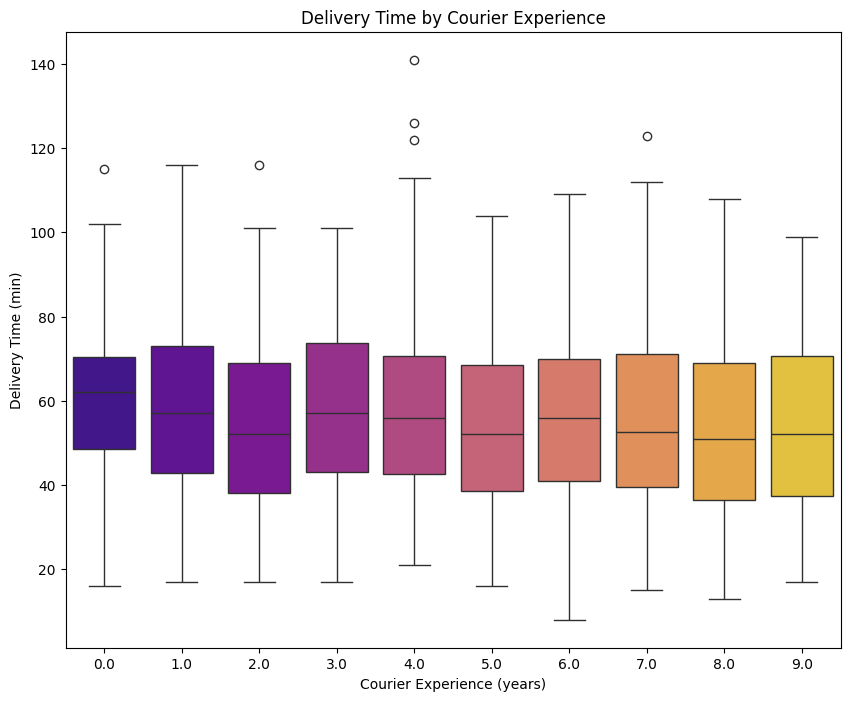

In [110]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df1,x='Courier_Experience_yrs',y='Delivery_Time_min',palette='plasma')
plt.title("Delivery Time by Courier Experience")
plt.xlabel("Courier Experience (years)")
plt.ylabel("Delivery Time (min)")
plt.show()

<Figure size 2000x1500 with 0 Axes>

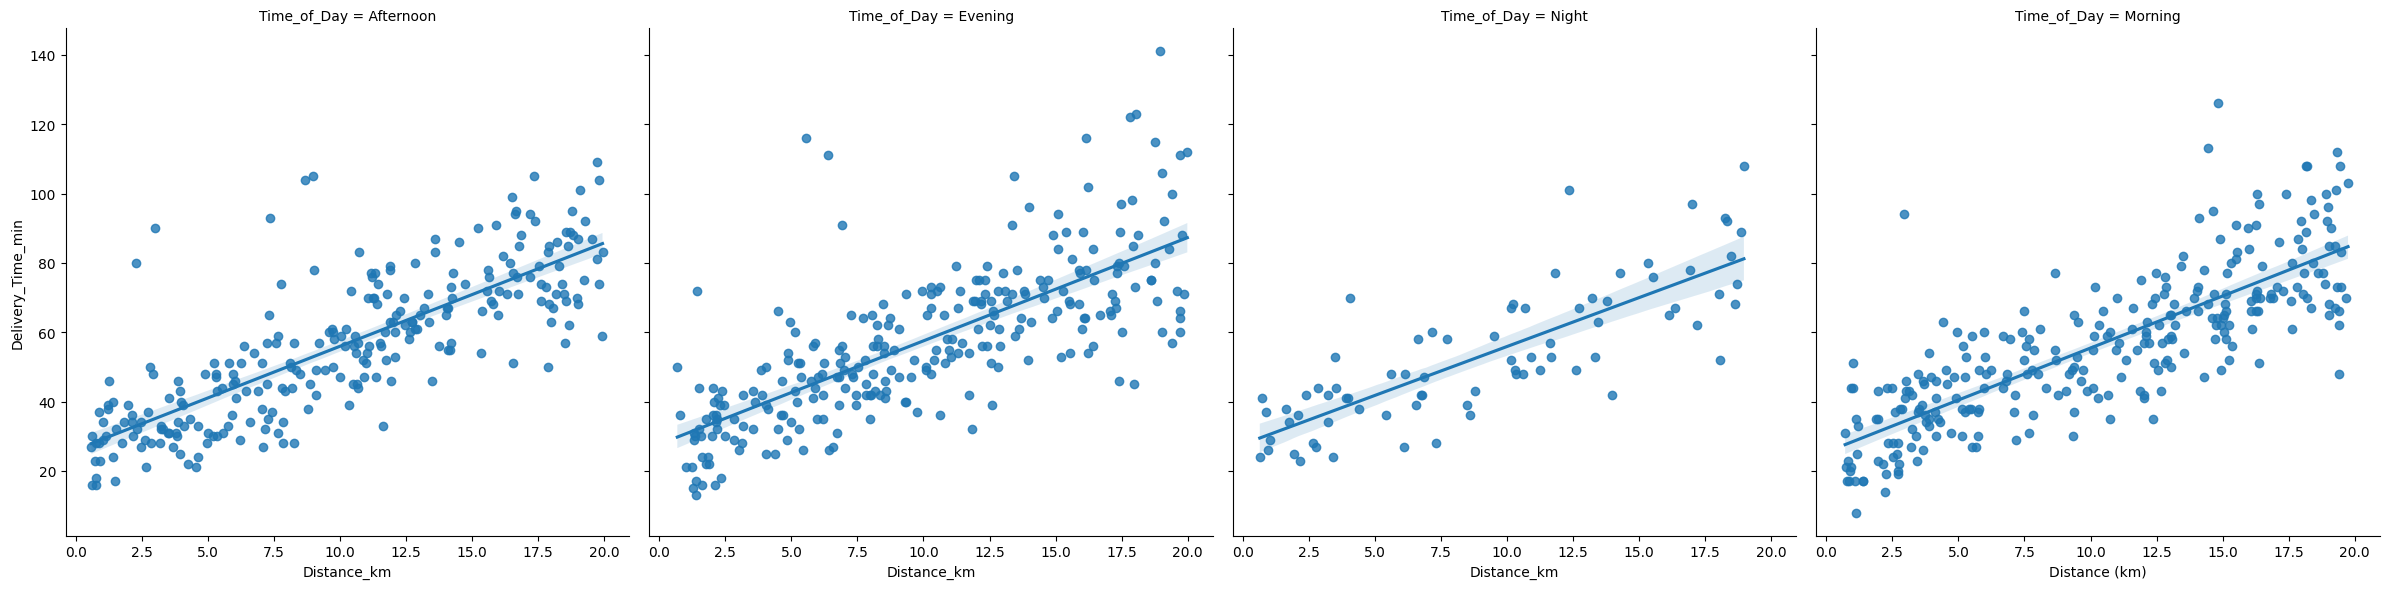

In [111]:
plt.figure(figsize=(20,15))
sns.lmplot(data=df1,x='Distance_km',y='Delivery_Time_min',col='Time_of_Day',height=6)
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (min)")
plt.show()

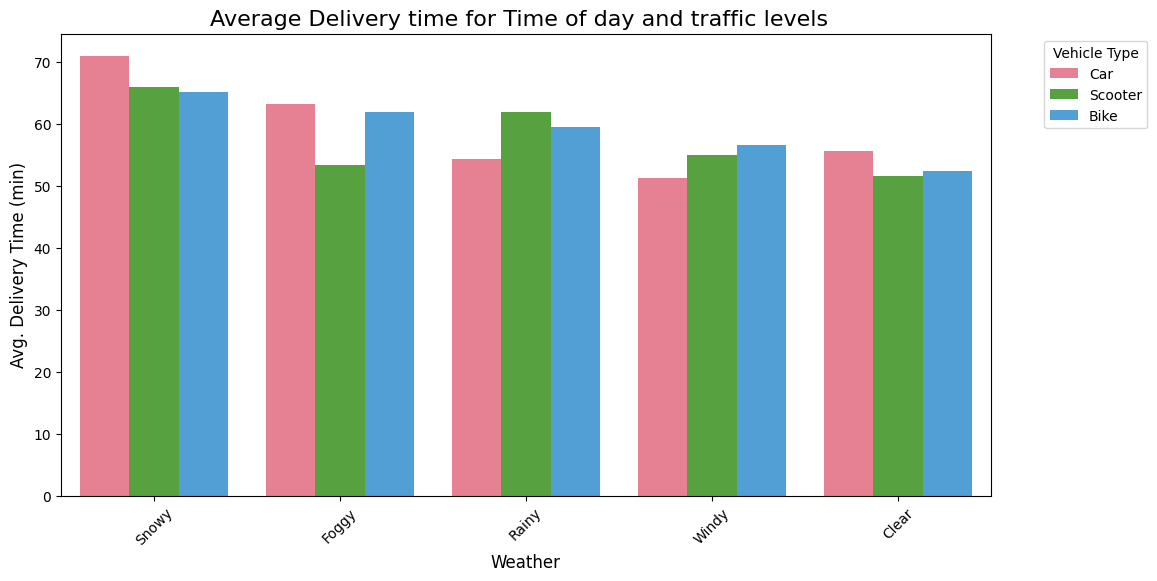

In [112]:
g1=df1.groupby(['Weather','Vehicle_Type'])['Delivery_Time_min'].mean().reset_index().sort_values(by='Delivery_Time_min',ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=g1,x='Weather',y='Delivery_Time_min',hue='Vehicle_Type',palette='husl')
ax.set_title('Average Delivery time for Time of day and traffic levels  ', fontsize=16)
ax.set_xlabel('Weather', fontsize=12)
ax.set_ylabel('Avg. Delivery Time (min)', fontsize=12)
ax.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

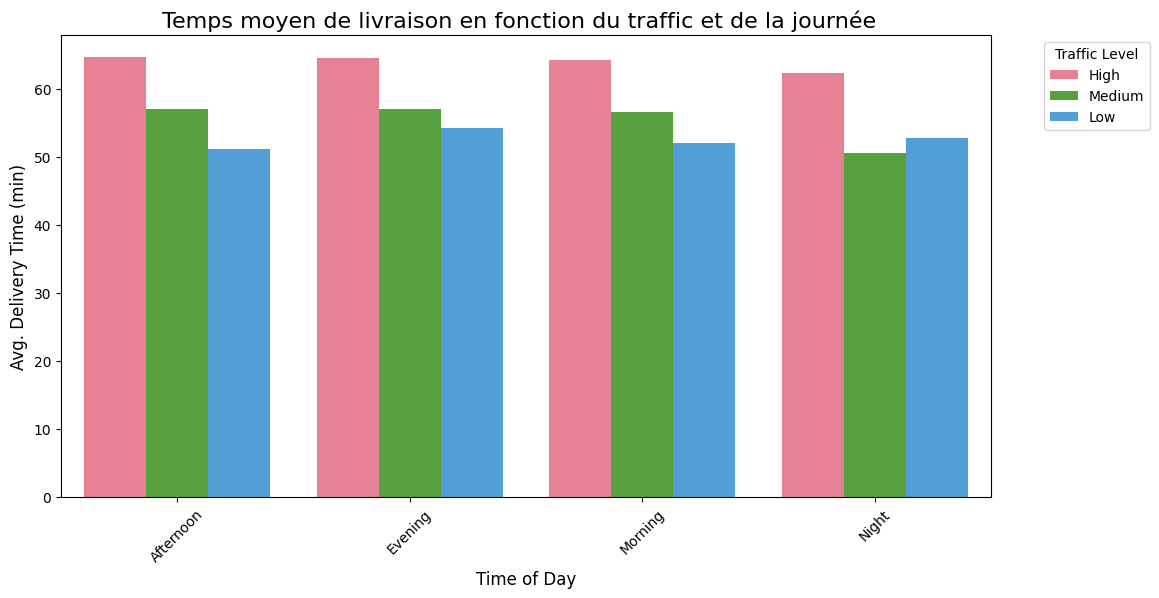

In [113]:
g2=df1.groupby(['Traffic_Level','Time_of_Day'])['Delivery_Time_min'].mean().reset_index().sort_values(by='Delivery_Time_min',ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=g2,x='Time_of_Day',y='Delivery_Time_min',hue='Traffic_Level',palette='husl')
ax.set_title('Temps moyen de livraison en fonction du traffic et de la journée  ', fontsize=16)
ax.set_xlabel('Time of Day', fontsize=12)
ax.set_ylabel('Avg. Delivery Time (min)', fontsize=12)
ax.legend(title='Traffic Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

On constate avec tout ces graphiques que, comme on l'attendait, la météo ainsi que le niveau de traffic affecte le temps de livraison. Plus la météo est compliqué, plus le temps de livraison se rallonge. Pareil pour le traffic. Surtout pour les voitures qui ne peuvnet pas faire d'interfile ou bien se faufiller entre d'autres voitures pour aller plus vite.  

<Axes: >

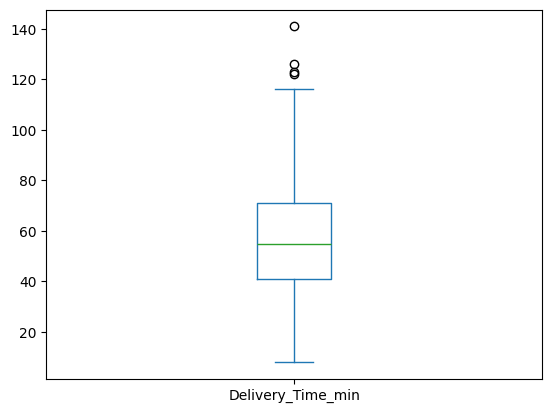

In [114]:
df1[['Delivery_Time_min']].plot.box()

On constate que ces points sont pas normal. ON verra plus bas pourquoi

<Axes: ylabel='Frequency'>

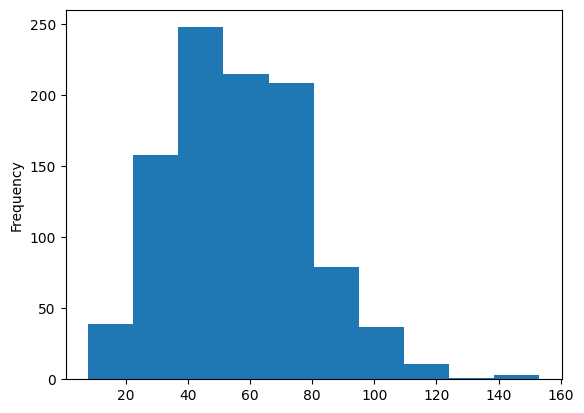

In [115]:
df.Delivery_Time_min.plot.hist()

In [116]:
px.scatter(df1, x="Distance_km", y="Delivery_Time_min", color='Vehicle_Type')

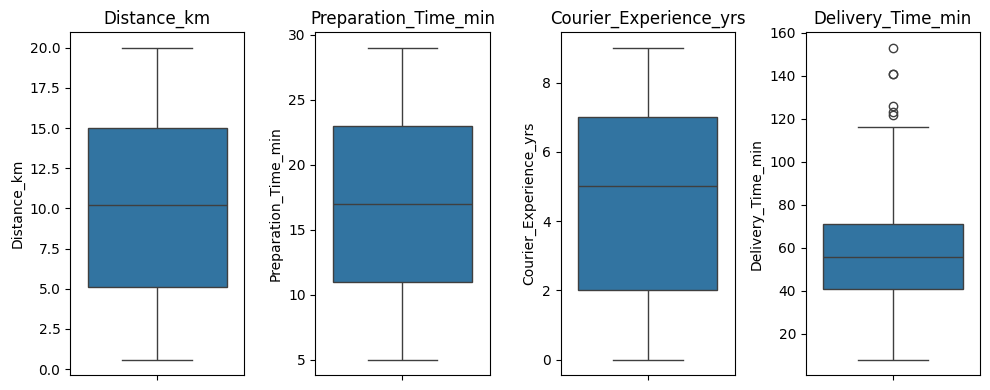

In [117]:
num_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']
plt.figure(figsize=(10, 4))

for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

Text(0.5, 1.02, 'Pairplot of the Data')

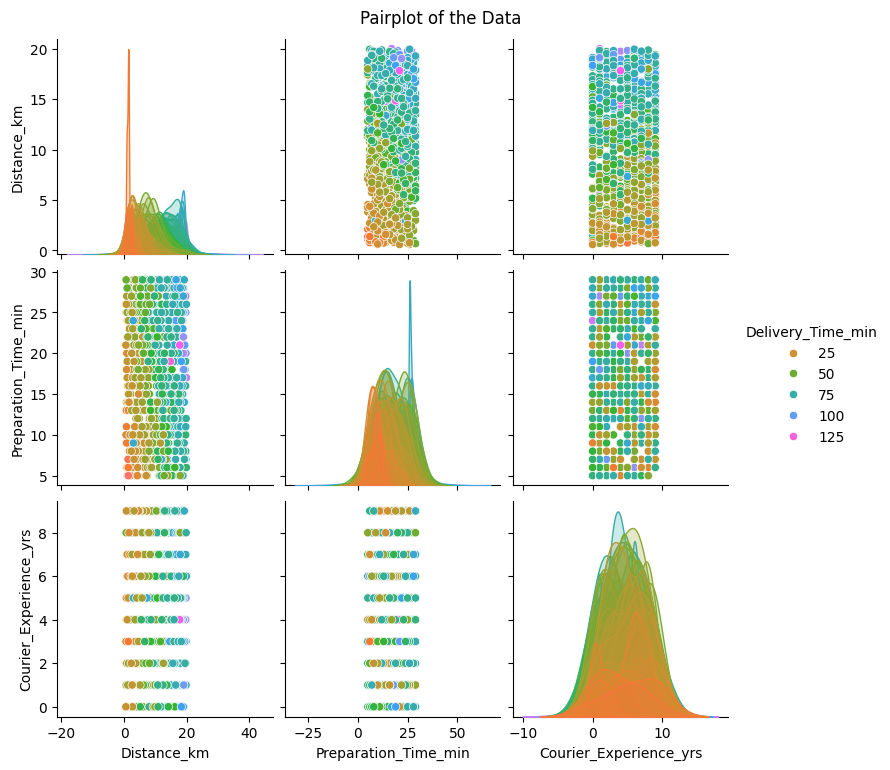

In [118]:
pairplot = sns.pairplot(df1, diag_kind='kde', kind='scatter', palette='husl', hue='Delivery_Time_min')
pairplot.fig.suptitle('Pairplot of the Data', y=1.02)

On va commencer notre pipeline

In [119]:
def data_preparation_0(df):
    df1 = df.drop(['Order_ID'], axis=1)
    df1.dropna(subset=['Weather','Traffic_Level','Time_of_Day','Courier_Experience_yrs'],inplace=True)
    return df1

In [120]:
df_train = data_preparation_0(df)
df_train.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [121]:
df_train.dtypes

Distance_km               float64
Weather                    object
Traffic_Level              object
Time_of_Day                object
Vehicle_Type               object
Preparation_Time_min        int64
Courier_Experience_yrs    float64
Delivery_Time_min           int64
dtype: object

In [122]:
df_train.dropna(subset=['Weather','Traffic_Level','Time_of_Day','Courier_Experience_yrs'],inplace=True)
df_train.isnull().sum()

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

In [123]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

# Je teste pour les catégories
display(cat_selector(df_train))
# Je teste pour les numeric
display(num_selector(df_train))

['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

['Distance_km',
 'Preparation_Time_min',
 'Courier_Experience_yrs',
 'Delivery_Time_min']

In [124]:
from sklearn.compose import make_column_transformer

# Encodeur pour les variables catégorielles, gère les valeurs inconnues et manquantes
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)

# Pour les "numeric" je choisis de remplacer les valeurs absentes par la moyenne meme si on les a supprimé earlier
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)


# J'assemble le tout pour faire une première pipeline de preprocessing et j'affiche le résumé
tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)

tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000226428F6B70>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002264295E5D0>)])

Parfait. Maintenant je vais préparer les données de train et de test 

In [125]:
from sklearn.model_selection import train_test_split

y = df_train.Delivery_Time_min
X = df_train.drop(['Delivery_Time_min'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

On test le modele RandomForestRegressor avec notre pipeline

In [126]:
from sklearn.ensemble import RandomForestRegressor

rfr_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))
rfr_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000226428F6B70>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002264295E5D0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [127]:
rfr_pipeline = rfr_pipeline.fit(X_train, y_train)

In [128]:
print("Train score", rfr_pipeline.score(X_train, y_train) *100)
print("Test score", rfr_pipeline.score(X_test, y_test) * 100)

Train score 95.7844194867602
Test score 75.81091816627429


Un gros ecart entre train et test donc on continue de tester d'autres modèle

In [129]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(tree_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000226428F6B70>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002264295E5D0>)])),
                ('lassocv', LassoCV())])

In [130]:
lasso_pipeline = lasso_pipeline.fit(X_train, y_train)

In [131]:
print("Train score", lasso_pipeline.score(X_train, y_train) *100)
print("Test score", lasso_pipeline.score(X_test, y_test) * 100)

Train score 72.08147902592597
Test score 77.59357257963926


Plus fort en Test qu'en train ?? On continue ! 

In [132]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
"""
Ce script effectue le prétraitement des données pour un modèle de régression linéaire en utilisant des transformateurs de colonnes. 
Il utilise OneHotEncoder pour encoder les variables catégorielles et StandardScaler avec SimpleImputer pour les variables numériques.
- cat_linear_processor : Un OneHotEncoder qui ignore les catégories inconnues.
- num_linear_processor : Un pipeline qui applique StandardScaler et SimpleImputer (avec la stratégie de moyenne et un indicateur supplémentaire) aux variables numériques.
- linear_preprocessor : Un transformateur de colonnes qui applique les préprocesseurs numériques et catégoriels aux colonnes sélectionnées.
"""

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000226428F6B70>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002264295E5D0>)])

In [133]:
lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000226428F6B70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002264295E5D0>)])),
                ('lassocv', LassoCV())])

In [134]:
lasso_pipeline = lasso_pipeline.fit(X_train, y_train)

In [135]:
print("Train score", lasso_pipeline.score(X_train, y_train) *100)
print("Test score", lasso_pipeline.score(X_test, y_test) * 100)

Train score 77.4226615637388
Test score 83.26787956167917


Non plus. On continue ! 

In [136]:
from sklearn.ensemble import RandomForestClassifier

rfc_pipeline = make_pipeline(tree_preprocessor, RandomForestClassifier(n_estimators=100, random_state=42))
rfc_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000226428F6B70>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002264295E5D0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [137]:
rfc_pipeline = rfc_pipeline.fit(X_train, y_train)

In [138]:
print("RandomForestClassifier : ")
print("Train score", rfc_pipeline.score(X_train, y_train) *100)
print("Test score", rfc_pipeline.score(X_test, y_test) * 100)
# Essaie d'autre modele pour voir si on peut améliorer le score

print('-'*50)

from sklearn.ensemble import GradientBoostingRegressor

gbr1_pipeline = make_pipeline(tree_preprocessor, GradientBoostingRegressor(n_estimators=100, random_state=42))
gbr1_pipeline

gbr1_pipeline = gbr1_pipeline.fit(X_train, y_train)

print("GradientBoostingRegressor : ")
print("Train score", gbr1_pipeline.score(X_train, y_train) *100)
print("Test score", gbr1_pipeline.score(X_test, y_test) * 100)
print('-'*50)

from sklearn.ensemble import AdaBoostRegressor

abr_pipeline = make_pipeline(tree_preprocessor, AdaBoostRegressor(n_estimators=100, random_state=42))
abr_pipeline

abr_pipeline = abr_pipeline.fit(X_train, y_train)

print("AdaBoostRegressor : ")
print("Train score", abr_pipeline.score(X_train, y_train) *100)
print("Test score", abr_pipeline.score(X_test, y_test) * 100)
print('-'*50)

from sklearn.ensemble import ExtraTreesRegressor

etr_pipeline = make_pipeline(tree_preprocessor, ExtraTreesRegressor(n_estimators=100, random_state=42))
etr_pipeline

etr_pipeline = etr_pipeline.fit(X_train, y_train)
print("ExtraTreesRegressor : ")
print("Train score", etr_pipeline.score(X_train, y_train) *100)
print("Test score", etr_pipeline.score(X_test, y_test) * 100)

print('-'*50)

from sklearn.ensemble import BaggingRegressor

br_pipeline = make_pipeline(tree_preprocessor, BaggingRegressor(n_estimators=100, random_state=42))
br_pipeline

br_pipeline = br_pipeline.fit(X_train, y_train)
print("BaggingRegressor : ")
print("Train score", br_pipeline.score(X_train, y_train) *100)
print("Test score", br_pipeline.score(X_test, y_test) * 100)

RandomForestClassifier : 
Train score 100.0
Test score 3.389830508474576
--------------------------------------------------
GradientBoostingRegressor : 
Train score 86.34697435272493
Test score 77.90788132323786
--------------------------------------------------
AdaBoostRegressor : 
Train score 59.819144441541525
Test score 46.20971758008808
--------------------------------------------------
ExtraTreesRegressor : 
Train score 99.99999568731216
Test score 76.64380385580587
--------------------------------------------------
BaggingRegressor : 
Train score 95.78597274321388
Test score 75.96225235251734


# Le meilleur modèle est le GradientBoostingRegressor

In [139]:
gbr1_pipeline.predict(X_test)

array([ 37.2672977 ,  31.65907146,  43.59241064,  83.54102333,
        47.90571881,  93.50037293,  80.89978601,  53.55597997,
        70.63352053,  62.71082879,  67.07465866,  45.57621997,
        15.88392406,  82.23048198,  87.33643925,  57.76477005,
        36.80627749,  83.21077812,  47.62529087,  28.81797762,
        73.13208832,  87.61056271,  64.95326203,  57.93237987,
        56.33244799,  72.54176729,  37.62806075,  44.33046726,
        23.2109001 ,  58.68387557, 104.58765721,  67.61025668,
        31.76823928,  47.74224161,  53.20644247,  10.77881471,
        54.98095116,  39.40359775,  66.1252315 ,  45.4500287 ,
        33.16511849,  34.82763081,  83.2063384 ,  54.21284958,
        55.45551434,  30.64694576,  77.77576792,  46.45674919,
        16.1356467 ,  67.44681318,  34.59508573,  91.78751417,
        46.81551301,  73.88915803,  59.42770186,  50.73673078,
        42.51910706,  42.92862903,  65.1846467 ,  61.09391214,
        32.89310563,  84.70421887,  47.3955931 ,  39.39

Pas de valeurs négatives et des temps en minute donc pour l'instant on est bon 

In [140]:
# Convert the predictions to a DataFrame with a column named "Delivery_Time_min"
y_predict = pd.DataFrame(y_predict, columns=["Delivery_Time_min"])

# Display the first few rows of the predictions DataFrame
y_predict.head()

,Delivery_Time_min
0,37.267298
1,31.659071
2,43.592411
3,83.541023
4,47.905719


Premiere aprecu des valeurs predite a coté des vrai valeurs

In [141]:
df_graph_predict = pd.concat([X_test.reset_index(drop=True), y_predict.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

   Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
0         2.09   Rainy           Low       Night         Bike   
1         0.59   Clear           Low   Afternoon         Bike   
2         4.53   Snowy        Medium     Morning      Scooter   
3        18.72   Rainy        Medium   Afternoon         Bike   
4         8.50   Clear          High     Evening          Car   

   Preparation_Time_min  Courier_Experience_yrs  y_predict  y_test    erreur  
0                    23                     2.0  37.267298      36 -1.267298  
1                    21                     0.0  31.659071      27 -4.659071  
2                    18                     4.0  43.592411      49  5.407589  
3                    17                     0.0  83.541023      89  5.458977  
4                    13                     3.0  47.905719      54  6.094281  


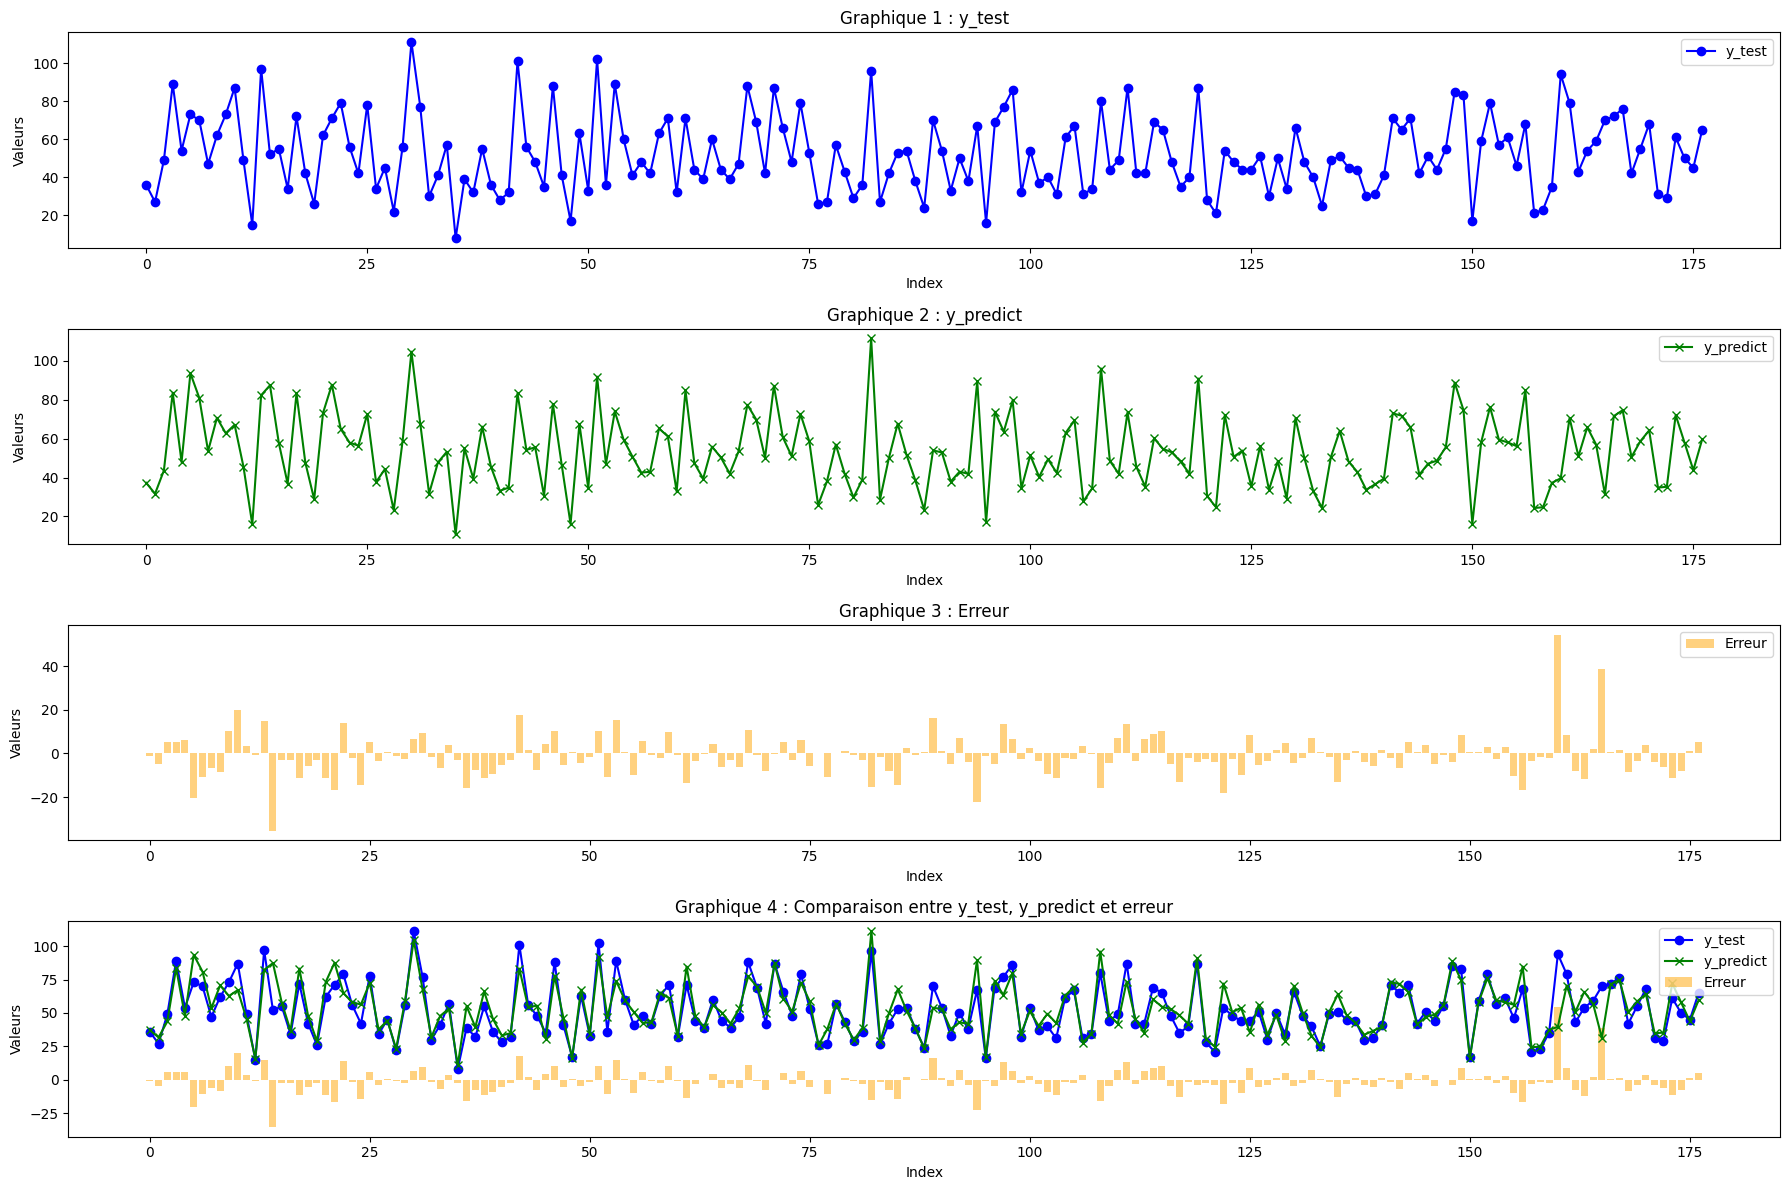

In [142]:
# Création de df_graph_predict
df_graph_predict = pd.concat([
    X_test.reset_index(drop=True),
    y_predict.reset_index(drop=True),
    y_test.reset_index(drop=True)
], axis=1)

# Renommer les colonnes pour plus de clarté
df_graph_predict.columns = list(X_test.columns) + ['y_predict', 'y_test']

# Calcul de la colonne "erreur"
df_graph_predict['erreur'] = df_graph_predict['y_test'] - df_graph_predict['y_predict']

# Affichage des premières lignes
print(df_graph_predict.head())

# Création des graphiques
plt.figure(figsize=(18, 12))

# Graphique 1 : y_test
plt.subplot(4, 1, 1)
plt.plot(df_graph_predict.index, df_graph_predict['y_test'], label='y_test', color='blue', marker='o')
plt.xlabel('Index')
plt.ylabel('Valeurs')
plt.title('Graphique 1 : y_test')
plt.legend()

# Graphique 2 : y_predict
plt.subplot(4, 1, 2)
plt.plot(df_graph_predict.index, df_graph_predict['y_predict'], label='y_predict', color='green', marker='x')
plt.xlabel('Index')
plt.ylabel('Valeurs')
plt.title('Graphique 2 : y_predict')
plt.legend()

# Graphique 3 : erreur
plt.subplot(4, 1, 3)
plt.bar(df_graph_predict.index, df_graph_predict['erreur'], alpha=0.5, label='Erreur', color='orange')
plt.xlabel('Index')
plt.ylabel('Valeurs')
plt.title('Graphique 3 : Erreur')
plt.legend()

# Graphique 4 : y_test, y_predict et erreur
plt.subplot(4, 1, 4)
plt.plot(df_graph_predict.index, df_graph_predict['y_test'], label='y_test', marker='o', color='blue')
plt.plot(df_graph_predict.index, df_graph_predict['y_predict'], label='y_predict', marker='x', color='green')
plt.bar(df_graph_predict.index, df_graph_predict['erreur'], alpha=0.5, label='Erreur', color='orange')
plt.xlabel('Index')
plt.ylabel('Valeurs')
plt.title('Graphique 4 : Comparaison entre y_test, y_predict et erreur')
plt.legend()
plt.tight_layout()
plt.show()


On constate qu'on a des valeurs assez absurde. Verifions ca de plus près 

In [143]:
df_graph_predict[df_graph_predict['erreur'] > 20]

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,y_predict,y_test,erreur
160,2.93,Clear,Medium,Morning,Bike,24,8.0,39.614293,94,54.385707
165,4.04,Snowy,Low,Night,Bike,11,9.0,31.295450,70,38.704550


On voit que la valeurs qui apparait le plus est "Evening" dans "Time_of_day" et "High" dans "Traffic_Level" Essayons de dupliquer ces valeurs dans le dataset et reprenons depuis le debut.  

In [144]:
#Duplicate the data from df2 with predicted +20 minutes  more than the original delivery time. Thsi line should help df_graph_predict[df_graph_predict['erreur'] > 20]

df3 = df_graph_predict.copy()
df3.head()

#Add more data with the "erreur" column greater than 20
df3 = df3[df3['erreur'] > 20]
df3.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,y_predict,y_test,erreur
160,2.93,Clear,Medium,Morning,Bike,24,8.0,39.614293,94,54.385707
165,4.04,Snowy,Low,Night,Bike,11,9.0,31.295450,70,38.704550


In [145]:

#Add the new data to the original data
df2 = df1
df2 = pd.concat([df2, df3], axis=0)

#delete nan values
df2.dropna(subset=['Weather','Traffic_Level','Time_of_Day','Courier_Experience_yrs'],inplace=True)

df2.shape
df2.head()

#delete the "erreur" column y_test and y_predict
df2 = df2.drop(['erreur','y_test','y_predict'], axis=1)
df2.head()

#check for missing values
df2.isnull().sum()

#delete missing values
df2.dropna(subset=['Weather','Traffic_Level','Time_of_Day','Courier_Experience_yrs', 'Delivery_Time_min'],inplace=True)

df2.shape


(883, 8)

In [146]:
from sklearn.compose import make_column_transformer

# Encodeur pour les variables catégorielles, gère les valeurs inconnues et manquantes
cat_tree_processor2 = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)

# Pour les "numeric" je choisis de remplacer les valeurs absentes par la moyenne meme si on les a supprimé earlier
num_tree_processor2 = SimpleImputer(strategy="mean", add_indicator=True)


# J'assemble le tout pour faire une première pipeline de preprocessing et j'affiche le résumé
tree_preprocessor2 = make_column_transformer(
    (num_tree_processor2, num_selector), (cat_tree_processor2, cat_selector)
)

tree_preprocessor2

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000226428F6B70>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002264295E5D0>)])

In [147]:
#Split df2 into X and y

y = df2.Delivery_Time_min
X = df2.drop(['Delivery_Time_min'], axis=1)


In [148]:
#find the columns with missing values
X.columns[X.isnull().any()]
print(X.columns[X.isnull().any()])

#Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train the model
gbr_pipeline = make_pipeline(tree_preprocessor, GradientBoostingRegressor(n_estimators=100, random_state=42))
gbr_pipeline = gbr_pipeline.fit(X2_train, y2_train)

#Evaluate the model
print("Train score", gbr_pipeline.score(X2_train, y2_train) *100)
print("Test score", gbr_pipeline.score(X2_test, y2_test) * 100)

print("Train score", gbr1_pipeline.score(X_train, y_train) *100)
print("Test score", gbr1_pipeline.score(X_test, y_test) * 100)



Index([], dtype='object')
Train score 86.34697435272493
Test score 77.90788132323786
Train score 86.34697435272493
Test score 77.90788132323786


In [149]:
gbr_pipeline.predict(X2_test)

array([ 37.2672977 ,  31.65907146,  43.59241064,  83.54102333,
        47.90571881,  93.50037293,  80.89978601,  53.55597997,
        70.63352053,  62.71082879,  67.07465866,  45.57621997,
        15.88392406,  82.23048198,  87.33643925,  57.76477005,
        36.80627749,  83.21077812,  47.62529087,  28.81797762,
        73.13208832,  87.61056271,  64.95326203,  57.93237987,
        56.33244799,  72.54176729,  37.62806075,  44.33046726,
        23.2109001 ,  58.68387557, 104.58765721,  67.61025668,
        31.76823928,  47.74224161,  53.20644247,  10.77881471,
        54.98095116,  39.40359775,  66.1252315 ,  45.4500287 ,
        33.16511849,  34.82763081,  83.2063384 ,  54.21284958,
        55.45551434,  30.64694576,  77.77576792,  46.45674919,
        16.1356467 ,  67.44681318,  34.59508573,  91.78751417,
        46.81551301,  73.88915803,  59.42770186,  50.73673078,
        42.51910706,  42.92862903,  65.1846467 ,  61.09391214,
        32.89310563,  84.70421887,  47.3955931 ,  39.39

In [150]:
# Convert the predictions to a DataFrame with a column named "Delivery_Time_min"
y_predict2 = pd.DataFrame(y_predict, columns=["Delivery_Time_min"])

# Display the first few rows of the predictions DataFrame
y_predict2.head()

,Delivery_Time_min
0,37.267298
1,31.659071
2,43.592411
3,83.541023
4,47.905719


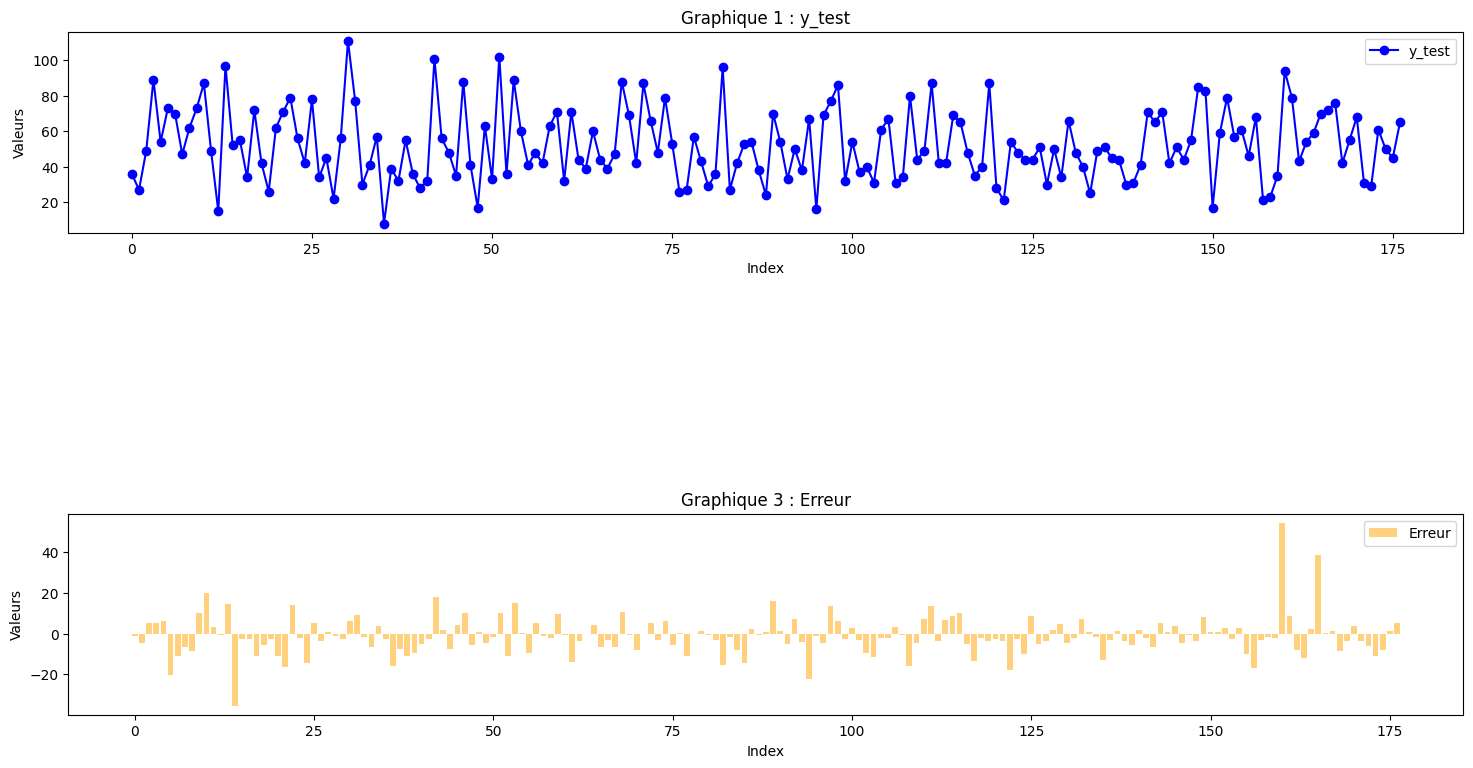

In [151]:
df_graph_predict2 = pd.concat([X2_test.reset_index(drop=True), y_predict2.reset_index(drop=True), y2_test.reset_index(drop=True)], axis=1) #+ y-test + colonne erreur = y-test - y-predict
df_graph_predict2.head()

# Création de df_graph_predict
df_graph_predict2 = pd.concat([
    X2_test.reset_index(drop=True),
    y_predict2.reset_index(drop=True),
    y2_test.reset_index(drop=True)
], axis=1)

# Renommer les colonnes pour plus de clarté
df_graph_predict2.columns = list(X2_test.columns) + ['y_predict', 'y_test']

# Calcul de la colonne "erreur"
df_graph_predict2['erreur'] = df_graph_predict2['y_test'] - df_graph_predict2['y_predict']

# Affichage des premières lignes

# Création des graphiques
plt.figure(figsize=(18, 12))

# Graphique 1 : y_test
plt.subplot(4, 1, 1)
plt.plot(df_graph_predict2.index, df_graph_predict2['y_test'], label='y_test', color='blue', marker='o')
plt.xlabel('Index')
plt.ylabel('Valeurs')
plt.title('Graphique 1 : y_test')
plt.legend()

# Graphique 3 : erreur 
plt.subplot(4, 1, 3)
plt.bar(df_graph_predict2.index, df_graph_predict2['erreur'], alpha=0.5, label='Erreur', color='orange')
plt.xlabel('Index')
plt.ylabel('Valeurs')
plt.title('Graphique 3 : Erreur')
plt.legend()




Les valeurs sont plus absurdes que la derniere fois. Par manque de temps, on va arrêté de jouer les sherlock. 

On a un bon modele qui sur-evalue quand il fait nuit et que le trafic et bouché. Comme ce n'est pas tres flagrant, on va travailler avec ce modele pour la suite 

In [152]:
#more score to prove that the fist try was better 
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipeline = make_pipeline(tree_preprocessor, GradientBoostingRegressor(n_estimators=100, random_state=42))
gbr_pipeline

gbr_pipeline = gbr_pipeline.fit(X2_train, y2_train)

print("GradientBoostingRegressor : ")
print("Train score", gbr_pipeline.score(X2_train, y2_train) *100)
print("Test score", gbr_pipeline.score(X2_test, y2_test) * 100)

print('-'*50)

#Show the data only when erreur > 20
df_graph_predict2[df_graph_predict2['erreur'] > 20]

GradientBoostingRegressor : 
Train score 86.34697435272493
Test score 77.90788132323786
--------------------------------------------------


,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,y_predict,y_test,erreur
160,2.93,Clear,Medium,Morning,Bike,24,8.0,39.614293,94.0,54.385707
165,4.04,Snowy,Low,Night,Bike,11,9.0,31.295450,70.0,38.704550


In [153]:
#Here's more metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_predict = gbr_pipeline.predict(X_test)
print("Mean Squared Error : ", mean_squared_error(y_test, y_predict))
print("Mean Absolute Error : ", mean_absolute_error(y_test, y_predict))
print("R2 Score : ", r2_score(y_test, y_predict))

Mean Squared Error :  90.2949435601174
Mean Absolute Error :  6.573603605459767
R2 Score :  0.7790788132323786


Généré par IA : Mean Squared Error (MSE) = 50: This value indicates the average squared difference between the predicted and actual values. Whether this is good depends on the scale of your target variable, as previously mentioned.

Mean Absolute Error (MAE) = 4: This value indicates the average absolute difference between the predicted and actual values. A lower MAE is generally better, and a value of 4 might be acceptable depending on the context and scale of your target variable.

R2 Score = 0.89: This is a good score, indicating that 89% of the variance in the target variable is explained by the model. An R2 score close to 1 is generally considered very good.

On va donc procéder a la mise en place de l'API maintenant qu'on a notre modèle 

In [154]:
import joblib
joblib.dump(gbr_pipeline, 'gbr_pipeline.pkl')



['gbr_pipeline.pkl']

In [163]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import joblib

def refresh_mlflow():
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://localhost:5000")

    # Assuming you have a trained model pipeline
    model_pipeline = Pipeline([
        ("preprocessor", tree_preprocessor),
        ("model", GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])

    # Train your model
    model_pipeline.fit(X_train, y_train)

    # Log the model with MLflow
    with mlflow.start_run() as run:
        mlflow.sklearn.log_model(model_pipeline, "model")
        mlflow.log_param("param1", "value1")
        mlflow.log_metric("metric1", 0.95)

        # Register the model
        mlflow.register_model(
            model_uri=f"runs:/{run.info.run_id}/model",
            name="DeliveryTimeModel"
        )

    # Save the model locally
    joblib.dump(model_pipeline, 'gbr_pipeline.pkl')

def load_latest_model():
    # Get the latest version of the model
    client = mlflow.tracking.MlflowClient()
    latest_version = client.get_latest_versions("DeliveryTimeModel", stages=["None"])[0].version
    return mlflow.sklearn.load_model(f"models:/DeliveryTimeModel/{latest_version}")

# Example usage
refresh_mlflow()
model = load_latest_model()

2025/01/11 16:18:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DeliveryTimeModel' already exists. Creating a new version of this model...
2025/01/11 16:18:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DeliveryTimeModel, version 4
Created version '4' of model 'DeliveryTimeModel'.


🏃 View run rumbling-toad-51 at: http://localhost:5000/#/experiments/0/runs/6b07572fd2944176a2e539203bae6cbc
🧪 View experiment at: http://localhost:5000/#/experiments/0


C:\Users\hayek\AppData\Local\Temp\ipykernel_4064\2132809352.py:38: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages

